In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive');

# import libraries
import scipy.sparse as sp
from scipy.sparse import coo_array
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
nltk.download('punkt');
nltk.download('stopwords');
from nltk.corpus import stopwords
from pprint import pprint
from collections import OrderedDict
import pickle
import math
from numba import none
from zmq import NULL
import string
from scipy.stats.distributions import chi2
from sklearn.metrics import confusion_matrix
import time
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet');
from nltk.tokenize import word_tokenize
import tensorflow as tf
import keras
!pip install keras_visualizer
import keras_visualizer
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# ***Data Import and Qualitative Analysis***

Use this section to import the raw training and testing data and examine it qualitatively.

In [ ]:
# read in data and print for manual inspection
trainData = pd.read_csv('/content/drive/MyDrive/ECE_537_CIS_568/Data/dataShuffledTrain.csv');
trainData

,class,rating,reviewText,reviewTitle
0,Bad,1,Got as a Holiday deal for $20......... If I pa...,Not impressed - want a refund
1,Good,5,"Built well, preforms well.","Built well, preforms well."
2,Bad,1,"low quality screws, one broken(left screw in p...",low quality screws
3,Bad,2,This router was very easy to setup. Its web-b...,Good router unless you enable WPA
4,Bad,1,"I Found the Correct Charger!, Feb 2nd, 2006\n\...",Finally found the RIGHT charger
...,...,...,...,...
149995,Neutral,3,"Its an ok signal, cheap. not the best connecti...",ok but not perfect
149996,Bad,2,Significant voltage drop under load over time....,Got weak over time.
149997,Bad,2,"Supposed to be 6ft cable, received 3ft cable.",3ft cable not 6
149998,Neutral,3,"First, let me say the Xbox 360 HDMI AV Cable t...",Close but not quite what I expected. 360 HDMI ...


In [ ]:
i = 291;
print(trainData.iloc[i]['rating']);
print(trainData.iloc[i]['reviewText']);

1
Would give 0 stars if I could. The worst product. The sound seems strange.


# ***Dictionary Building (1-grams)***

This section outlines the feature-selection process using 1-grams (single terms). The text data for the entire corpus is first tokenized, and then decomposed into term-frequency. Various feature importance metrics are then implemented to determine which terms are the most impactful for classification.

## ***TF/DF Computation***

Tokenize and decompose raw text into term frequency and document frequency. For each term in the whole corpus, the following elements are retrieved:

*   (allAbsFreq) The total number of times the word appears in the corpus.
*   (posAbsFreq) The total number of times the word appears in positive reviews.
*   (negAbsFreq) The total number of times the word appears in negative reviews.
*   (neuAbsFreq) The total number of times the word appears in neutral reviews.
*   (absDocFreq) The total number of documents the term appears in.
*   (absDocFreq2c) The total number of documents the term appears in, not including neutral documents. Used for 2-class problems later on.



In [ ]:
# @title
# =================================================
# == If dataframes are not saved, run this code! ==
# =================================================

n = len(trainData.index); dfArr = []; df = pd.DataFrame();
for i in range(0, n):

  # tokenize and get term freqency
  text = trainData.iloc[i]['reviewText']; sent = trainData.iloc[i]['class'];
  dft = pd.DataFrame(TextBlob(text.replace("'", "")).word_counts.items(), columns = ['term', 'allAbsFreq']);

  # add a column of 1s for the document frequency and for the class term frequency. add a column of 0s for the other 2 class term frequencies.
  dft['posAbsFreq'] = [0] * len(dft.index); dft['neuAbsFreq'] = [0] * len(dft.index); dft['negAbsFreq'] = [0] * len(dft.index);
  if (sent == "Good"): dft['posAbsFreq'] = dft['allAbsFreq'];
  elif (sent == "Neutral"): dft['neuAbsFreq'] = dft['allAbsFreq'];
  else: dft['negAbsFreq'] = dft['allAbsFreq'];
  dft['absDocFreq'] = [1] * len(dft.index);
  if sent == "Neutral":
    dft['absDocFreq2c'] = [0] * len(dft.index);
  else:
    dft['absDocFreq2c'] = [1] * len(dft.index);
  dfArr.append(dft);

  # print progress
  if (i % 1000 == 0):
    print("\rGenerating DF Chunks ...", math.trunc(1000*i/n)/10, "%", end = "");

# aggregate DF chunks into main DF
print("\rGenerating DF Chunks ...", 100.0, "%\nAggregating DF Chunks into Master DF...");
df = pd.concat(dfArr, ignore_index = True);
df['allAbsFreq'] = df['allAbsFreq'].astype(int); df['posAbsFreq'] = df['posAbsFreq'].astype(int); df['neuAbsFreq'] = df['neuAbsFreq'].astype(int);
df['negAbsFreq'] = df['negAbsFreq'].astype(int); df['absDocFreq'] = df['absDocFreq'].astype(int); df['absDocFreq2c'] = df['absDocFreq2c'].astype(int);
df = df.groupby('term', as_index = False).sum(numeric_only = True);
print("Writing DF to CSV file...");
df.to_csv('/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/tfDataFrame.csv', index = False);

Generating DF Chunks ... 100.0 %
Aggregating DF Chunks into Master DF...
Writing DF to CSV file...


In [ ]:
# ===========================================
# == If dataframe is saved, run this code! ==
# ===========================================

# read dataframe from files so the code above doesn't have to be run more than once
df = pd.read_csv('/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/tfDataFrame.csv');

In [ ]:
# sort and display dataframe by absolute frequency
df.sort_values(by = ['allAbsFreq'], ascending = False, ignore_index = True, inplace = True);
df['absDocFreq2c'] = df['absDocFreq2c'].astype(int);
df

,term,allAbsFreq,posAbsFreq,neuAbsFreq,negAbsFreq,absDocFreq,absDocFreq2c
0,the,724870,183238,280400,261232,110727,71816
1,i,393448,104793,138770,149885,98490,64954
2,to,372285,96127,139925,136233,97783,63733
3,a,344168,95414,128928,119826,97529,63527
4,and,330931,98813,113953,118165,98580,66505
...,...,...,...,...,...,...,...
122170,coincided,1,0,1,0,1,0
122171,ni_mh,1,0,0,1,1,1
122172,coincedence,1,0,0,1,1,1
122173,niah4,1,1,0,0,1,1


## ***Dataframe Cleaning***

Clean the raw dataframe from the previous subsection. This includes checking for and removing null instances, removing stop-words using a known list of common stop-words, and removing infrequently used terms. The frequency threshold can be adjusted by changing the value of thresh to a percentage of documents in the corpus. By default, it is 0.001, meaning that terms occurring in less than 150 documents are removed from the dictionary.

In [ ]:
# @title
# step 1: remove null values
print("Removed", df.isnull().any(axis=1).sum(), "null instances: ", df.shape[0], " --> ", end = "");
df = df.dropna();
print(df.shape[0], "\n");
n = df.shape[0];

# step 2: remove stopwords
print("Stopwords: ", stopwords.words('english'));
stop_words = set(stopwords.words('english'));
print("Searching for ", len(stop_words), " stop-words to remove...");

for word in stop_words:
  word = word.replace("'", "");
  df = df[df['term'] != word];

print("Removed", n - df.shape[0] ,"stop-words: ", n, " --> ", df.shape[0], "\n");
n = df.shape[0];

# step 3: reset DF indices and filter to words that have a frequency of less than 0.1% of the corpus.
ndocs = 150000;
thresh = ndocs * 0.001;
print("Removing instances that occur in less than", thresh, "documents.");

df.reset_index(inplace = True);
df = df.drop(['index'], axis = 1);
df_filtered = df[df['absDocFreq'] >= thresh];

# step 4: re-sort
df_filtered = df_filtered.sort_values(by = ['allAbsFreq'], ascending = False, ignore_index = True);
print("Removed", n - df_filtered.shape[0] ,"low-frequency instances: ", n, " --> ", df_filtered.shape[0]);

# step 5: compute IDF
df_filtered['logIDF'] = np.log(150000 / (df_filtered['absDocFreq'] + 1));
df_filtered['logIDF2c'] = np.log(150000 / (df_filtered['absDocFreq2c'] + 1));

Removed 2 null instances:  122175  --> 122173 

Stopwords:  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such'

In [ ]:
# print
df_filtered.to_csv('/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/tfDataFrameFiltered.csv', index = False);
df_filtered

,term,allAbsFreq,posAbsFreq,neuAbsFreq,negAbsFreq,absDocFreq,absDocFreq2c,logIDF,logIDF2c
0,one,56870,15112,19791,21967,36200,23839,1.421549,1.839270
1,use,45729,14270,17518,13941,32199,20301,1.538669,1.999916
2,good,45567,15014,19096,11457,33422,20059,1.501391,2.011908
3,would,43533,9435,16512,17586,30441,19031,1.594812,2.064514
4,get,40240,9072,15449,15719,28558,17812,1.658663,2.130707
...,...,...,...,...,...,...,...,...,...
4009,well-made,154,77,58,19,152,96,6.887953,7.343680
4010,decently,153,34,81,38,151,71,6.894510,7.641724
4011,everybody,153,50,53,50,153,100,6.881438,7.303270
4012,hesitant,152,80,36,36,152,116,6.887953,7.156217


## ***Feature Importance Metrics***

Compute various feature importance metrics to rank each term in its ability to classify a review. Ideal terms are those that occur very frequently in one class, and very infrequently in all other classes. For example, we might expect that the term "terrible" occurs often in negative reviews, but seldom in positive reviews or neutral reviews. There are currently four metrics implemented.

*   ChiSq3c is the 3-class Chi-Squared Test Metric
*   ChiSq2c is the 2-class Chi-Squared Test Metric. Selecting this removes the neutral class from the training and testing data.
*   GINI3c is the 3-class GINI Impurity Metric
*   GINI2c is the 2-class GINI Impurity Metric. Selecting this removes the neutral class from the training and testing data.

### ***Chi-Squared Test (3-Class)***

In [ ]:
# read dataframe from files so the code above doesn't have to be run more than once
df_filtered = pd.read_csv('/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/tfDataFrameFiltered.csv');

npos = df_filtered['posAbsFreq'].sum();
nneu = df_filtered['neuAbsFreq'].sum();
nneg = df_filtered['negAbsFreq'].sum();
print("N+: ", npos, "N~: ", nneu, "N-: ", nneg);

N+:  1622608 N~:  2210397 N-:  2174577


In [ ]:
# observed values for each class
observed_pos = df_filtered['posAbsFreq'];
observed_neu = df_filtered['neuAbsFreq'];
observed_neg = df_filtered['negAbsFreq'];

# probability of observing the term in each class
prob_pos = npos / (npos + nneg + nneu);
prob_neu = nneu / (npos + nneg + nneu);
prob_neg = nneg / (npos + nneg + nneu);

# expected values for each class
sample_size = df_filtered['allAbsFreq'];
expected_pos = (prob_pos * sample_size);
expected_neu = (prob_neu * sample_size);
expected_neg = (prob_neg * sample_size);

# chi-square parts
chi_sqr_pos = ((observed_pos - expected_pos) ** 2) / expected_pos;
chi_sqr_neu = ((observed_neu - expected_neu) ** 2) / expected_neu;
chi_sqr_neg = ((observed_neg - expected_neg) ** 2) / expected_neg;

# chi-square value for each term
df_filtered['ChiSq3c'] = chi_sqr_pos + chi_sqr_neu + chi_sqr_neg;

In [ ]:
#top words by chi-square value
df_filtered.sort_values(by = ['ChiSq3c'], ascending = False, ignore_index = True, inplace = True);
df_top_chi = df_filtered.head(100);
df_top_chi

,term,allAbsFreq,posAbsFreq,neuAbsFreq,negAbsFreq,absDocFreq,absDocFreq2c,logIDF,logIDF2c,ChiSq3c
0,great,36423,19176,10567,6680,28865,20557,1.647971,1.987385,12672.602107
1,works,26515,11291,9715,5509,23385,14914,1.858498,2.308268,4123.119161
2,perfect,5784,3532,1451,801,5272,3965,3.348036,3.632877,3497.215984
3,easy,12389,6042,4096,2251,10592,7138,2.650442,3.045063,3331.113704
4,excellent,5467,3298,1380,789,4802,3617,3.441395,3.724714,3160.448177
...,...,...,...,...,...,...,...,...,...,...
95,zoom,3676,1432,1584,660,2192,1288,4.225365,4.756769,571.819895
96,value,2754,1258,955,541,2431,1597,4.121921,4.541882,567.229189
97,small,11612,3774,4845,2993,9454,5591,2.764092,3.289298,554.832333
98,stars,6274,1352,3194,1728,5410,2737,3.322201,4.003408,538.823299


### ***Chi-Squared Test (Binomial)***

In [ ]:
# observed values for each class
observed_pos = df_filtered['posAbsFreq'];
observed_neg = df_filtered['negAbsFreq'];

# probability of observing the term in each class
prob_pos = npos / (npos + nneg);
prob_neg = nneg / (npos + nneg);

# expected values for each class
sample_size = df_filtered['allAbsFreq'] - df_filtered['neuAbsFreq'];
expected_pos = (prob_pos * sample_size);
expected_neg = (prob_neg * sample_size);

# chi-square parts
chi_sqr_pos = ((observed_pos - expected_pos) ** 2) / expected_pos;
chi_sqr_neg = ((observed_neg - expected_neg) ** 2) / expected_neg;

# chi-square value for each term
df_filtered['ChiSq2c'] = chi_sqr_pos + chi_sqr_neg;

In [ ]:
#top words by chi-square value
df_filtered.sort_values(by = ['ChiSq2c'], ascending = False, ignore_index = True, inplace = True);
df_top_chi = df_filtered.head(100);
df_top_chi

,term,allAbsFreq,posAbsFreq,neuAbsFreq,negAbsFreq,absDocFreq,absDocFreq2c,logIDF,logIDF2c,ChiSq3c,ChiSq2c
0,great,36423,19176,10567,6680,28865,20557,1.647971,1.987385,12672.602107,10439.047593
1,works,26515,11291,9715,5509,23385,14914,1.858498,2.308268,4123.119161,4112.840531
2,easy,12389,6042,4096,2251,10592,7138,2.650442,3.045063,3331.113704,3075.345922
3,perfect,5784,3532,1451,801,5272,3965,3.348036,3.632877,3497.215984,2663.093230
4,lens,18999,7897,7012,4090,6760,4291,3.099464,3.553882,2620.002397,2624.620114
...,...,...,...,...,...,...,...,...,...,...,...
95,bag,6429,2217,2705,1507,3108,1878,3.876334,4.379896,470.766322,429.545920
96,luck,1892,197,591,1104,1807,1245,4.418414,4.790697,465.369972,404.674036
97,completely,3730,593,1179,1958,3397,2329,3.787448,4.164767,471.403665,395.817075
98,poorly,1191,74,351,766,1134,799,4.884003,5.233779,468.208449,394.989957


### ***GINI Impurity Test (3-Class)***

In [ ]:
# add GINI impurity column (1 - sum(pi^2))
df_filtered['GINI3c'] = 1 - (df_filtered['posAbsFreq'] / df_filtered['allAbsFreq'])**2 - (df_filtered['neuAbsFreq'] / df_filtered['allAbsFreq'])**2 - (df_filtered['negAbsFreq'] / df_filtered['allAbsFreq'])**2;
df_filtered.sort_values(by = ['GINI3c'], ascending = True, ignore_index = True, inplace = True);
df_top_gini = df_filtered.head(100);
df_top_gini

,term,allAbsFreq,posAbsFreq,neuAbsFreq,negAbsFreq,absDocFreq,absDocFreq2c,logIDF,logIDF2c,ChiSq3c,ChiSq2c,GINI3c
0,garbage,1104,43,94,967,1002,912,5.007640,5.101655,1263.915664,610.943573,0.224022
1,junk,2417,125,210,2082,2166,1977,4.237292,4.328549,2611.137231,1239.188473,0.247769
2,refund,1783,43,281,1459,1619,1356,4.528209,4.705359,1639.456296,975.609641,0.304992
3,waste,2905,155,372,2378,2752,2406,3.997944,4.132254,2632.863057,1387.498051,0.310668
4,pos,224,10,32,182,202,184,6.605185,6.698035,198.603412,110.469852,0.317443
...,...,...,...,...,...,...,...,...,...,...,...,...
95,attempts,371,33,104,234,362,258,6.023988,6.361563,126.843137,100.647310,0.515689
96,shame,745,67,208,470,708,510,5.354535,5.682021,254.294440,200.866644,0.515962
97,pleased,1816,1171,405,240,1739,1345,4.456750,4.713498,1312.767948,934.515227,0.517000
98,unusable,736,38,258,440,705,468,5.358775,5.767788,243.764644,236.305583,0.517058


### ***GINI Impurity Test (2-Class)***

In [ ]:
# add GINI impurity column (1 - sum(pi^2))
df_filtered['GINI2c'] = 1 - (df_filtered['posAbsFreq'] / (df_filtered['allAbsFreq'] - df_filtered['neuAbsFreq']))**2 - (df_filtered['negAbsFreq'] / (df_filtered['allAbsFreq'] - df_filtered['neuAbsFreq']))**2;
df_filtered.sort_values(by = ['GINI2c'], ascending = True, ignore_index = True, inplace = True);
df_top_gini = df_filtered.head(100);
df_top_gini

,term,allAbsFreq,posAbsFreq,neuAbsFreq,negAbsFreq,absDocFreq,absDocFreq2c,logIDF,logIDF2c,ChiSq3c,ChiSq2c,GINI3c,GINI2c
0,refund,1783,43,281,1459,1619,1356,4.528209,4.705359,1639.456296,975.609641,0.304992,0.055618
1,garbage,1104,43,94,967,1002,912,5.007640,5.101655,1263.915664,610.943573,0.224022,0.081523
2,lemon,274,10,72,192,266,199,6.331142,6.620073,150.459165,117.826208,0.438596,0.094108
3,rma,464,18,101,345,370,287,6.002189,6.255430,307.009313,211.645490,0.398270,0.094256
4,unacceptable,503,18,140,345,489,352,5.723985,6.051923,259.015159,211.645490,0.450814,0.094256
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,shame,745,67,208,470,708,510,5.354535,5.682021,254.294440,200.866644,0.515962,0.218401
96,rep,374,34,102,238,291,217,6.241637,6.533896,131.465170,101.586013,0.512397,0.218750
97,bokeh,323,187,109,27,225,164,6.497856,6.812445,184.043603,174.348143,0.543952,0.220500
98,receipt,289,29,60,200,253,203,6.381056,6.600271,138.002924,84.602435,0.467906,0.221201


## ***Save Results***

In [ ]:
df_filtered.to_csv('/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/featureImportanceDataFrame.csv', index = False);

# ***TF-IDF Feature Extraction***

Creates a feature matrix from a selection of features (terms). To try different feature matrices, change the value of numTopValues and importanceMetric. Higher values of numTopValues increase the robustness of the model trained using the data, but comes at the cost of a higher model complexity due to more terms in the dictionary. There are four different values for importanceMetric:

*   ChiSq3c is the 3-class Chi-Squared Test Metric
*   ChiSq2c is the 2-class Chi-Squared Test Metric. Selecting this removes the neutral class from the training and testing data.
*   GINI3c is the 3-class GINI Impurity Metric
*   GINI2c is the 2-class GINI Impurity Metric. Selecting this removes the neutral class from the training and testing data.

Current feature vectors:

*   ChiSq3c250
*   ChiSq3c500
*   ChiSq2c250
*   ChiSq2c500


In [ ]:
# read in dataframe with feature importance metrics
frame = pd.read_csv('/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/featureImportanceDataFrame.csv');

# sort by desired metric and grab top values
numTopValues = 500; importanceMetric = 'GINI2c'; #metrics are ChiSq3c, ChiSq2c, GINI3c, and GINI2c
frame.sort_values(by = [importanceMetric], ascending = False, ignore_index = True, inplace = True);
terms = frame.head(numTopValues);

# training and testing dataframes
trainData = pd.read_csv('/content/drive/MyDrive/ECE_537_CIS_568/Data/dataShuffledTrain.csv');
testData = pd.read_csv('/content/drive/MyDrive/ECE_537_CIS_568/Data/dataShuffledTest.csv');
validData = pd.read_csv('/content/drive/MyDrive/ECE_537_CIS_568/Data/dataShuffledValidation.csv');

# if using 2-class metric, then drop neutral instances
if importanceMetric == "ChiSq2c" or importanceMetric == "GINI2c":

  trainData = trainData[trainData['class'] != "Neutral"];
  trainData.reset_index(drop = True, inplace = True);

  testData = testData[testData['class'] != "Neutral"];
  testData.reset_index(drop = True, inplace = True);

  validData = validData[validData['class'] != "Neutral"];
  validData.reset_index(drop = True, inplace = True);

fTrain = "/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/trainSparseFeatureMatrix" + importanceMetric + str(numTopValues) + ".npz";
fTest  = "/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/testSparseFeatureMatrix" + importanceMetric + str(numTopValues) + ".npz";
fValid = "/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/validationSparseFeatureMatrix" + importanceMetric + str(numTopValues) + ".npz";

In [ ]:
# for training data
n = len(trainData.index); k = len(terms.index);
featureMatrix = np.zeros((n,k+1)); termList = [0]*k; logIDF = [0]*k;
for i in range(0, k):
  termList[i] = terms.iloc[i]['term'];
  if importanceMetric == 'ChiSq3c' or importanceMetric == 'GINI3c':
    logIDF[i] = terms.iloc[i]['logIDF'];
  else:
    logIDF[i] = terms.iloc[i]['logIDF2c'];

for i in range(0, n):

  # tokenize data
  text = trainData.iloc[i]['reviewText']; sent = trainData.iloc[i]['class'];
  text = TextBlob(text.replace("'", ""));
  numWords = len(text.words);
  words = text.word_counts;

  # convert to TF feature vector
  features = np.zeros((1,k+1));
  if (sent == "Good"):
    features[0, 0] = 0;
  elif (sent == "Bad"):
    features[0, 0] = 1;
  else:
    features[0, 0] = 2;

  for j in range(0, k):
    features[0, j+1] = words[termList[j]];
    features[0, j+1] = (features[0, j+1] / (numWords + 1)) * logIDF[j];

  featureMatrix[i] = features;

  # print progress
  if (i % 1000 == 0):
    print("\rGenerating Feature Matrix ...", math.trunc(1000*i/n)/10, "%", end = "");

print("\n");

# save as sparse matrix to save space
cooArr = coo_array(featureMatrix);
sp.save_npz(fTrain, cooArr);

Generating Feature Matrix ... 98.0 %

In [ ]:
# for testing data
n = len(testData.index); k = len(terms.index);
featureMatrix = np.zeros((n,k+1)); termList = [0]*k; logIDF = [0]*k;
for i in range(0, k):
  termList[i] = terms.iloc[i]['term'];
  if importanceMetric == 'ChiSq3c' or importanceMetric == 'GINI3c':
    logIDF[i] = terms.iloc[i]['logIDF'];
  else:
    logIDF[i] = terms.iloc[i]['logIDF2c'];

for i in range(0, n):

  # tokenize data
  text = testData.iloc[i]['reviewText']; sent = testData.iloc[i]['class'];
  text = TextBlob(text.replace("'", ""));
  numWords = len(text.words);
  words = text.word_counts;

  # convert to TF feature vector
  features = np.zeros((1,k+1));
  if (sent == "Good"):
    features[0, 0] = 0;
  elif (sent == "Bad"):
    features[0, 0] = 1;
  else:
    features[0, 0] = 2;

  for j in range(0, k):
    features[0, j+1] = words[termList[j]];
    features[0, j+1] = (features[0, j+1] / (numWords + 1)) * logIDF[j];

  featureMatrix[i] = features;

  # print progress
  if (i % 1000 == 0):
    print("\rGenerating Feature Matrix ...", math.trunc(1000*i/n)/10, "%", end = "");

print("\n");

# save as sparse matrix to save space
cooArr = coo_array(featureMatrix);
sp.save_npz(fTest, cooArr);

Generating Feature Matrix ... 95.0 %



In [ ]:
# for validation data
n = len(validData.index); k = len(terms.index);
featureMatrix = np.zeros((n,k+1)); termList = [0]*k; logIDF = [0]*k;
for i in range(0, k):
  termList[i] = terms.iloc[i]['term'];
  if importanceMetric == 'ChiSq3c' or importanceMetric == 'GINI3c':
    logIDF[i] = terms.iloc[i]['logIDF'];
  else:
    logIDF[i] = terms.iloc[i]['logIDF2c'];

for i in range(0, n):

  # tokenize data
  text = validData.iloc[i]['reviewText']; sent = validData.iloc[i]['class'];
  text = TextBlob(text.replace("'", ""));
  numWords = len(text.words);
  words = text.word_counts;

  # convert to TF feature vector
  features = np.zeros((1,k+1));
  if (sent == "Good"):
    features[0, 0] = 0;
  elif (sent == "Bad"):
    features[0, 0] = 1;
  else:
    features[0, 0] = 2;

  for j in range(0, k):
    features[0, j+1] = words[termList[j]];
    features[0, j+1] = (features[0, j+1] / (numWords + 1)) * logIDF[j];

  featureMatrix[i] = features;

  # print progress
  if (i % 1000 == 0):
    print("\rGenerating Feature Matrix ...", math.trunc(1000*i/n)/10, "%", end = "");

print("\n");

# save as sparse matrix to save space
cooArr = coo_array(featureMatrix);
sp.save_npz(fValid, cooArr);

Generating Feature Matrix ... 95.0 %



# ***Logistic Regression***

In [ ]:
# load and uncompress feature matrices. write the filenames of the matrices to load. make sure they utilize the same feature encoding.
featureSet = 'ChiSq2c250';
trainMatrix = sp.load_npz("/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/trainSparseFeatureMatrix" + featureSet + ".npz");
trainMatrix = trainMatrix.todense();
testMatrix = sp.load_npz("/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/testSparseFeatureMatrix" + featureSet + ".npz");
testMatrix = testMatrix.todense();
validMatrix = sp.load_npz("/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/validationSparseFeatureMatrix" + featureSet + ".npz");
validMatrix = validMatrix.todense();

# create design matrices
ntr = trainMatrix.shape[0]; k = trainMatrix.shape[1]; ytr = np.asarray(np.matrix.copy(trainMatrix[:,0]));
numC = len(np.unique(ytr)); classLabels = np.unique(ytr);
if numC > 2:
  classNames = ['Good', 'Bad', 'Neutral'];
else:
  classNames = ['Good', 'Bad'];
print("Training Instances: ", ntr, ", Classes: ", numC, ", Features: ", k, sep = "");
for i in range (0, ntr):
  trainMatrix[i,0] = 1;

ntst = testMatrix.shape[0]; ytst = np.asarray(np.matrix.copy(testMatrix[:,0]));
for i in range(0, ntst):
  testMatrix[i,0] = 1;

nval = validMatrix.shape[0]; yvalid = np.asarray(np.matrix.copy(validMatrix[:,0]));
for i in range(0, nval):
  validMatrix[i,0] = 1;

# logistic regression parameters
learnRate = 1e-1;
learnRateDecayCoefficient = 0.92; # use 1 to disable
maxEpochs = 50;
batchSize = 256;
L2Coeff = 1e-4; # use 0 to disable
L2Epoch = 40;
numModels = numC;
dw = np.zeros((k, 1));
if numC > 2:
  beta = np.zeros((k, numC));
else:
  beta = np.zeros((k, 1));
  numModels = 1;

Training Instances: 100000, Classes: 2, Features: 251


In [ ]:
# train logistic regression model(s) using SGD
for c in range(0, numModels):

  microSecPerIter = 0;
  learnRate = 1e-1;

  print("Training Model ", c+1, "/", numModels, end = "\n", sep = "");

  for i in range(0, maxEpochs):

    epochStartTime = time.time_ns();

    # stochastically permute data
    perm = np.random.permutation(ntr);
    XtrShf = trainMatrix[perm]; ytrShf = ytr[perm];
    if numC > 2:
      ytrShf = ytrShf == classLabels[c];
    else:
      ytrShf = ytrShf == 1;

    # run batch training
    for j in range(0, ntr - batchSize, batchSize):

      # get batch
      Xbatch = XtrShf[j:j+batchSize];
      ybatch = ytrShf[j:j+batchSize];

      # predict
      p = 1.0 / (1.0 + np.exp(np.matmul(-Xbatch, beta[:,c])));
      e = np.transpose(p) - ybatch;

      # update weights
      dw[0] = np.sum(e);
      dw[1:] = np.matmul(np.transpose(Xbatch[:,1:]), e);
      if j > L2Epoch:
        dw = dw + L2Coeff * beta[:,c].reshape((-1,1));

      beta[:,c] = (beta[:,c].reshape((-1,1)) - learnRate * dw).reshape((-1,));

    # evaluate performance
    p = 1.0 / (1.0 + np.exp(np.matmul(-validMatrix, beta[:,c])));
    if numC > 2:
      acc = np.mean((yvalid == classLabels[c]) == np.transpose(p > 0.5));
    else:
      acc = np.mean((yvalid == 1) == np.transpose(p > 0.5));
    print("\rEpoch ", i+1, " validation accuracy: ", math.trunc(10000*acc)/100, "%", sep = "", end = "");

    microSecPerIter = microSecPerIter + (time.time_ns() - epochStartTime) / (1000*maxEpochs);
    learnRate = learnRate * learnRateDecayCoefficient;

  print("\nAverage training time per epoch: ", np.trunc(microSecPerIter/1000), " ms", sep = "");

Training Model 1/1
Epoch 50 validation accuracy: 84.47%
Average training time per epoch: 127.0 ms


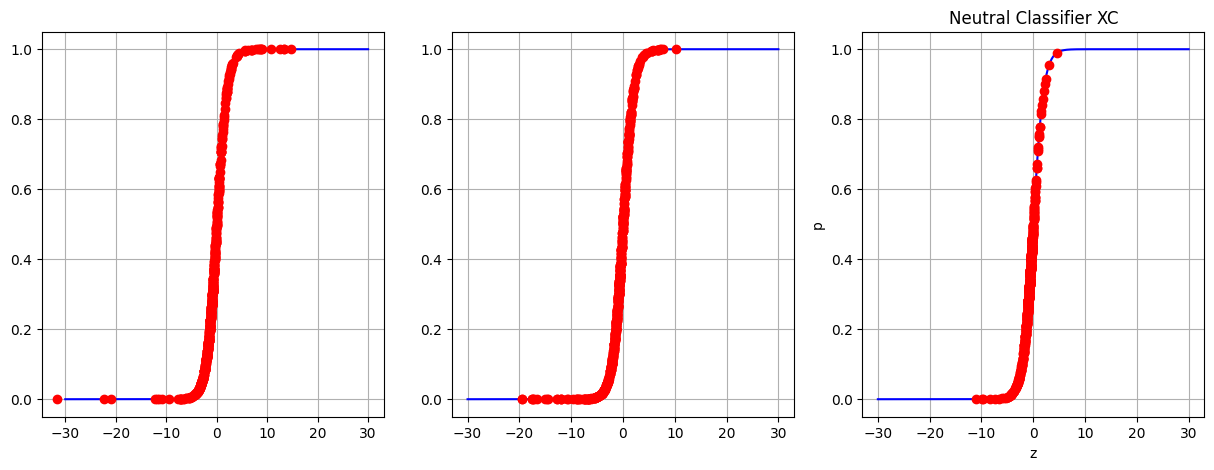

In [ ]:
# plot transfer characteristics
xsig = np.linspace(-30, 30, 2000);
ysig = 1.0 / (1.0 + np.exp(-xsig));
fig, axs = plt.subplots(1, numModels);
titles = ["Positive Classifier XC", "Negative Classifier XC", "Neutral Classifier XC"];
fn = ["pos.csv", "neg.csv", "neu.csv"];
for c in range(0, numModels):
  z = np.matmul(validMatrix[::50,:], beta[:,c]);
  np.savetxt(fn[c], z, delimiter = ",");
  p = 1.0 / (1.0 + np.exp(-z));
  if numModels > 1:
    axs[c].plot(xsig, ysig, 'b-', z, p, 'ro');
    axs[c].grid();
    plt.xlabel("z");
    plt.ylabel("p");
    plt.title(titles[c]);
  else:
    axs.plot(xsig, ysig, 'b-', z, p, 'ro');
    axs.grid();
    axs.xlabel("z");
    axs.ylabel("p");
    axs.title("Transfer Characteristic");


fig.set_figheight(5);
fig.set_figwidth(15);
plt.show();

In [ ]:
#fn = ["pos.csv", "neg.csv", "neu.csv"];
fn = ["binary.csv"];
for c in range(0, numModels):
  z = np.matmul(validMatrix[:,:], beta[:,c]);
  np.savetxt(fn[c], z, delimiter = ",");

In [ ]:
# evaluate multi-model logistic regression classifier
p = np.zeros((numModels, ntst));
for c in range(0, numModels):
  p[[c]] = (1.0 / (1.0 + np.exp(np.matmul(-testMatrix, beta[:,c]))));

if numModels > 1:
  ypred = (np.argmax(p, axis=0)).reshape((ntst,1));
else:
  ypred = np.transpose(p > 0.5);

idx = ["TruePos", "TrueNeg", "TrueNeu"]; col = ["PredPos", "PredNeg", "PredNeu"];
acc = np.mean(ypred == ytst);
print("Accuracy: ", np.trunc(10000*acc)/100, "%", sep = ""); print("Confusion Matrix:\n");
cm = pd.DataFrame(confusion_matrix(ytst, np.asarray(ypred), labels = classLabels),
                  index = idx[:numC],
                  columns = col[:numC]);
print(cm);

Accuracy: 83.92%
Confusion Matrix:

         PredPos  PredNeg
TruePos     8138     1862
TrueNeg     1354     8646


# ***Decision Tree***

***Decision Tree - 3-Class Classifier***

In [ ]:
# load and uncompress feature matrices for 3 classes
trainMatrix = sp.load_npz("/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/trainSparseFeatureMatrixChiSq3c250.npz");
trainMatrix = trainMatrix.todense();
testMatrix = sp.load_npz("/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/testSparseFeatureMatrixChiSq3c250.npz");
testMatrix = testMatrix.todense();

trainArray3c = np.array(trainMatrix)
testArray3c = np.array(testMatrix)


# create model parameters
ytrn3c = trainArray3c[:,0] # should I use copy?
xtrn3c = trainArray3c[:,1].reshape(-1,1)

ytest3c = testArray3c[:,0]
xtest3c = testArray3c[:,1].reshape(-1,1)

# # importing the decision tree classifier from sklearn
# from sklearn.tree import DecisionTreeClassifier

# # classification report and confusion matrix
# from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


# # generating a confusion matrix
# from sklearn import metrics
# from sklearn.model_selection import StratifiedKFold

# intializing decision tree classfiier
dtc = DecisionTreeClassifier()

# # using grid search to test over given hyperparamer values
# from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [5, 8, 10, 12, 14, 16],
    'min_samples_split': [50, 100, 200, 300, 500, 1000],
    'min_samples_leaf': [50, 100, 200, 300, 500],
}


# Create StratifiedKFold
stratified_cv3c = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)

# Create the GridSearchCV object with stratified sampling
grid_search = GridSearchCV(dtc, param_grid, cv=stratified_cv3c, scoring='accuracy')


grid_search = GridSearchCV(dtc, param_grid, cv=10, scoring='accuracy')
grid_search.fit(xtrn3c, ytrn3c)

best_params = grid_search.best_params_
best_dt_model = grid_search.best_estimator_

# print("Best Parameters: ",best_params)
print("Best Model: ", best_dt_model)

# predicting on xtest
yproba3c = best_dt_model.predict_proba(xtest3c)[:,1]

ypred3c = best_dt_model.predict(xtest3c)

df_accuracy = accuracy_score(ytest3c, ypred3c)
print(f"Accuracy of Decison Tree Model: {df_accuracy}")

Best Model:  DecisionTreeClassifier(max_depth=14, min_samples_leaf=50,
                       min_samples_split=1000)
Accuracy of Decison Tree Model: 0.4026666666666667


In [ ]:
# # generating a confusion matrix
# from sklearn import metrics

# cm3c = metrics.confusion_matrix(ytest3c, ypred3c)

# dtc_cm3c = pd.DataFrame(data=cm3c, columns=['predict: Good','predict: Bad', 'predict: Neutral'],
#                     index=['true: Good', 'true: Bad', 'true: Neutral'])
# classifier report
print(classification_report(ytest3c,ypred3c))



              precision    recall  f1-score   support

         0.0       0.61      0.26      0.36     10000
         1.0       0.37      0.89      0.52     10000
         2.0       0.40      0.06      0.10     10000

    accuracy                           0.40     30000
   macro avg       0.46      0.40      0.33     30000
weighted avg       0.46      0.40      0.33     30000



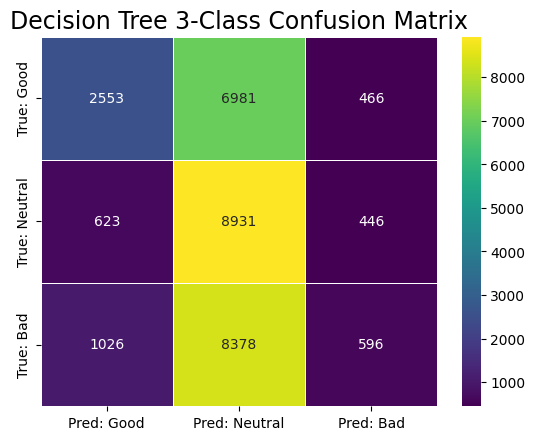

In [ ]:
# creating confusion matrix visualization
# import seaborn as sns
cm3c = metrics.confusion_matrix(ytest3c, ypred3c)

# dtc_cm3c = pd.DataFrame(data=cm3c, columns=['predict: Good','predict: Bad', 'predict: Neutral'],
#                     index=['true: Good', 'true: Bad', 'true: Neutral'])

sns.heatmap(cm3c,
            annot=True,
            fmt='g',
            linewidth=.5,
            xticklabels=['Pred: Good','Pred: Bad', 'Pred: Neutral'],
            yticklabels=['True: Good','True: Bad', 'True: Neutral'],
            cmap='viridis')

plt.title('Decision Tree 3-Class Confusion Matrix',fontsize=17)
plt.show()

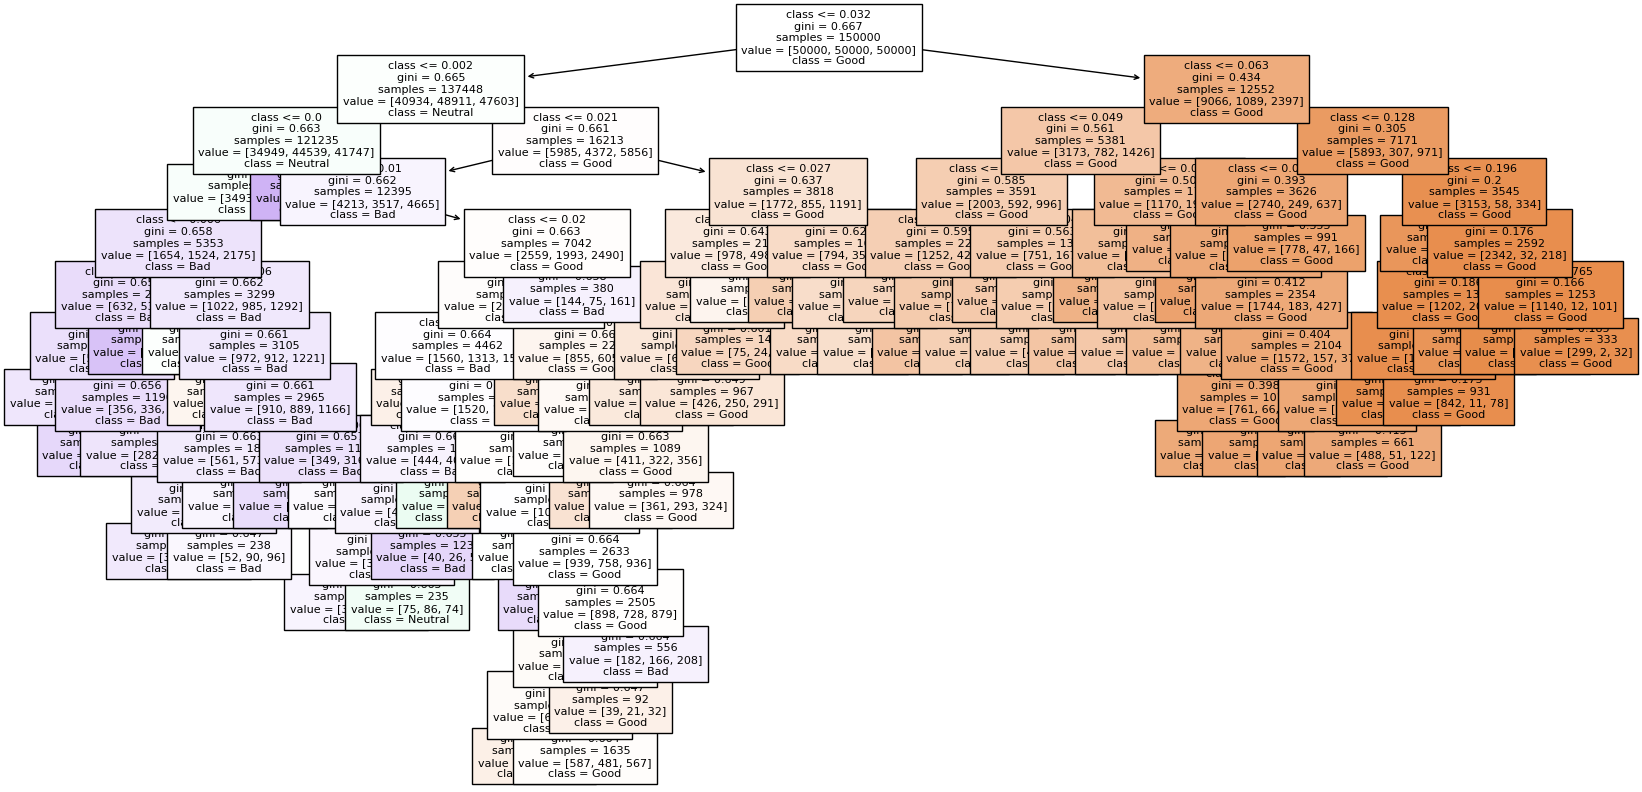

In [ ]:
# visualizing the actual decision tree
# from sklearn import tree

feature_names = trainData.columns

dtc_fig = plt.figure(figsize=(20,10))

_ = tree.plot_tree(best_dt_model,
                  feature_names=feature_names,
                  class_names={0:'Good', 1: 'Neutral', 2: 'Bad'},
                  filled=True,
                  fontsize=8)



***Decision Tree - 2-Class Classifier***

In [ ]:
# intializing decision tree classfiier
dtc = DecisionTreeClassifier()

# using grid search to test over given hyperparamer values
# from sklearn.model_selection import GridSearchCV

param_grid2c = {
    'max_depth': [5, 8, 10, 12, 14, 16],
    'min_samples_split': [50, 100, 200, 300, 500, 1000],
    'min_samples_leaf': [50, 100, 200, 300, 500],
}

# Create StratifiedKFold
stratified_cv2c = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

# Create the GridSearchCV object with stratified sampling
grid_search = GridSearchCV(dtc, param_grid2c, cv=stratified_cv2c, scoring='accuracy')

grid_search.fit(xtrn2c, ytrn2c)

best_params = grid_search.best_params_
best_dt_model2c = grid_search.best_estimator_

# print("Best Parameters: ",best_params)
print("Best Model: ", best_dt_model2c)

# predicting on xtest
yproba = best_dt_model2c.predict_proba(xtest2c)[:,1]

ypred2c = best_dt_model2c.predict(xtest2c)



Best Model:  DecisionTreeClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50)


              precision    recall  f1-score   support

         0.0       0.74      0.31      0.43     10000
         1.0       0.56      0.89      0.69     10000

    accuracy                           0.60     20000
   macro avg       0.65      0.60      0.56     20000
weighted avg       0.65      0.60      0.56     20000



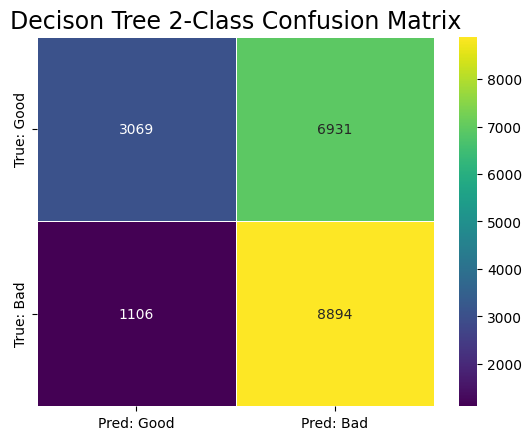

In [ ]:
# classifier report
print(classification_report(ytest2c, ypred2c))

# generating a confusion matrix
# from sklearn import metrics

cm2c = metrics.confusion_matrix(ytest2c, ypred2c)

sns.heatmap(cm2c,
            annot=True,
            fmt='g',
            linewidth=.5,
            xticklabels=['Pred: Good', 'Pred: Bad'],
            yticklabels=['True: Good','True: Bad'],
            cmap='viridis')

plt.title('Decison Tree 2-Class Confusion Matrix',fontsize=17)
plt.show()

Accuracy of Decison Tree Model: 0.59815


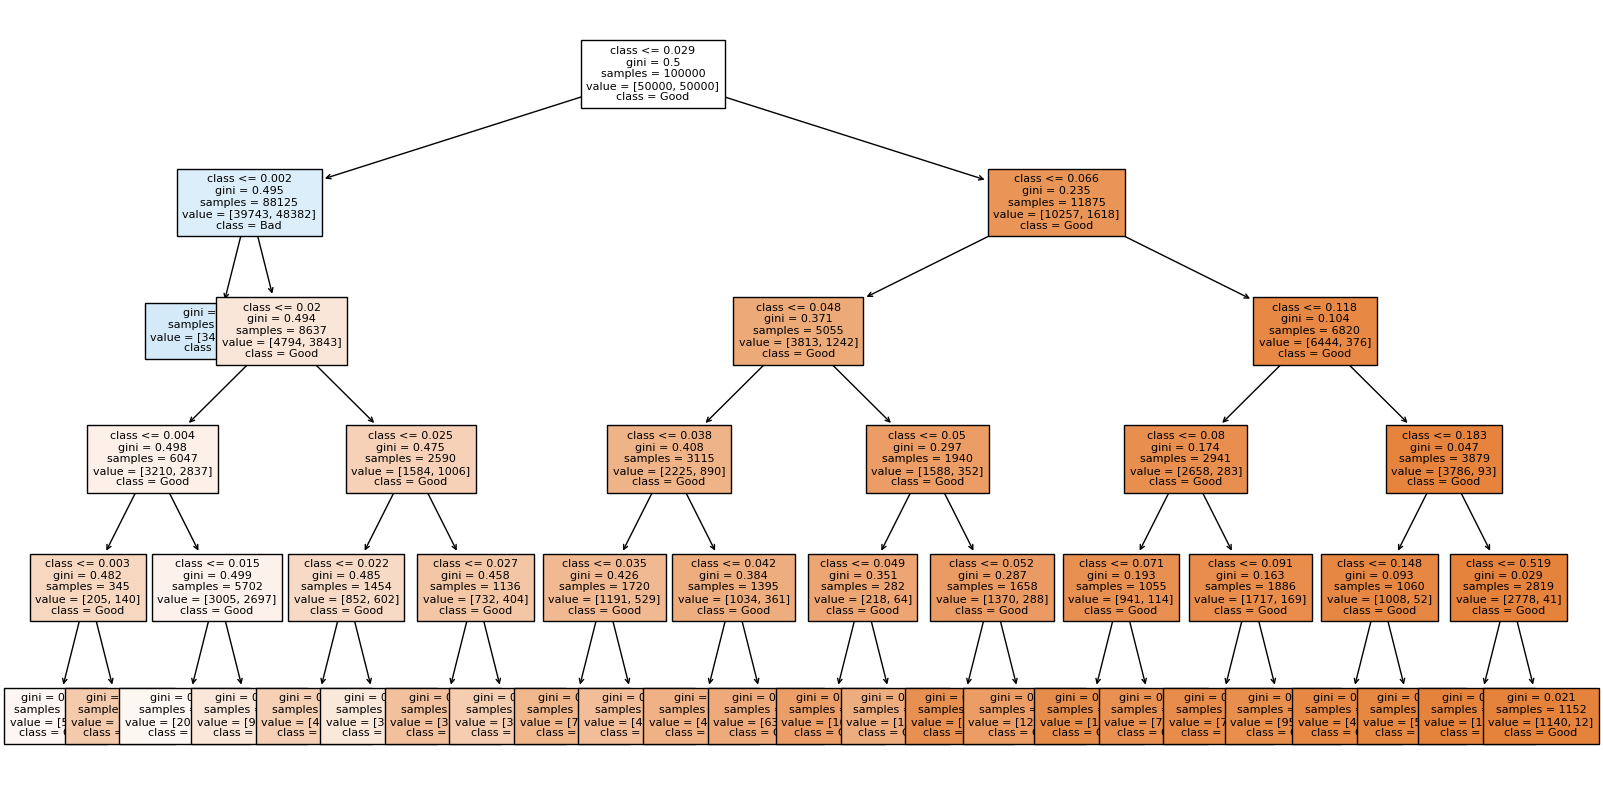

In [ ]:
# visualizing the actual decision tree
# from sklearn import tree

feature_names = trainData.columns

dtc_fig = plt.figure(figsize=(20,10))

figure = tree.plot_tree(best_dt_model2c,
                  feature_names=feature_names,
                  class_names={0:'Good', 1: 'Bad'},
                  filled=True,
                  fontsize=8)


df_accuracy = accuracy_score(ytest2c, ypred2c)
print(f"Accuracy of Decison Tree Model: {df_accuracy}")

# ***K-NN***

KNN 3-Class Classifier

In [ ]:
# load and uncompress feature matrices for 3 classes
trainMatrix = sp.load_npz("/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/trainSparseFeatureMatrixChiSq3c250.npz");
trainMatrix = trainMatrix.todense();
testMatrix = sp.load_npz("/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/testSparseFeatureMatrixChiSq3c250.npz");
testMatrix = testMatrix.todense();

trainArray3c = np.array(trainMatrix)
testArray3c = np.array(testMatrix)


# create model parameters
ytrn3c = trainArray3c[:,0] # should I use copy?
xtrn3c = trainArray3c[:,1].reshape(-1,1)

ytest3c = testArray3c[:,0]
xtest3c = testArray3c[:,1].reshape(-1,1)


In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score


knn_clf=KNeighborsClassifier()


# Create StratifiedKFold
stratified_KNN3c = StratifiedKFold(n_splits=5, shuffle=True, random_state=57)

# defining a range of values for n_neighbors to test in grid search
knn_param_grid3c = {'n_neighbors' : [25, 50, 75, 100, 125],
              'metric' : ['euclidean', 'manhattan']}

# create a grid search to assess best amount of n_neighbors per cluster
knn_grid_search3c = GridSearchCV(knn_clf, knn_param_grid3c, cv=stratified_KNN3c)

# fit the knn model to the training data
knn_grid_search3c.fit(xtrn3c, ytrn3c)

# printing the best hyperparameters found by the grid search
print("Best Hyperparameters:", knn_grid_search3c.best_params_)

# identifying the best model
best_knn_model3c = knn_grid_search3c.best_estimator_
print('Best KNN Model: ', best_knn_model3c)

# make predictions on the test data
knn_preds3c = best_knn_model3c.predict(xtest3c)




Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 125}
Best KNN Model:  KNeighborsClassifier(metric='euclidean', n_neighbors=125)


Accuracy of Decison Tree Model: 0.4004333333333333
              precision    recall  f1-score   support

         0.0       0.61      0.25      0.35     10000
         1.0       0.37      0.89      0.52     10000
         2.0       0.37      0.06      0.10     10000

    accuracy                           0.40     30000
   macro avg       0.45      0.40      0.33     30000
weighted avg       0.45      0.40      0.33     30000



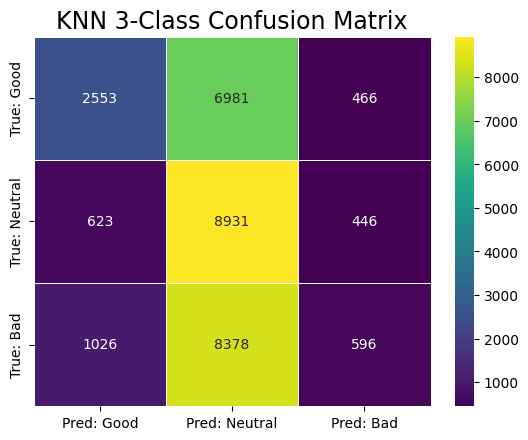

In [ ]:
# printing exact accuracy score
knn_accuracy3c = accuracy_score(ytest3c, knn_preds3c)
print(f"Accuracy of Decison Tree Model: {knn_accuracy3c}")

# evaluating accruacy with classfication report
print(classification_report(ytest3c,knn_preds3c))

# generating a confusion matrix
# from sklearn import metrics

Knn_cm3c = metrics.confusion_matrix(ytest3c, ypred3c)

sns.heatmap(Knn_cm3c,
            annot=True,
            fmt='g',
            linewidth=.5,
            xticklabels=['Pred: Good','Pred: Bad', 'Pred: Neutral'],
            yticklabels=['True: Good','True: Bad', 'True: Neutral'],
            cmap='viridis')

plt.title('KNN 3-Class Confusion Matrix',fontsize=17)
plt.show()

KNN 2-Class Classifier

In [ ]:
# load and uncompress feature matrices for 3 classes
trainMatrix = sp.load_npz("/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/trainSparseFeatureMatrixChiSq2c250.npz");
trainMatrix = trainMatrix.todense();
testMatrix = sp.load_npz("/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/testSparseFeatureMatrixChiSq2c250.npz");
testMatrix = testMatrix.todense();

trainArray2c = np.array(trainMatrix)
testArray2c = np.array(testMatrix)


# create model parameters
ytrn2c = trainArray2c[:,0] # should I use copy?
xtrn2c = trainArray2c[:,1].reshape(-1,1)

ytest2c = testArray2c[:,0]
xtest2c = testArray2c[:,1].reshape(-1,1)

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score


knn_clf=KNeighborsClassifier()

# Create StratifiedKFold
stratified_KNN2c = StratifiedKFold(n_splits=5, shuffle=True, random_state=66)

# defining a range of values for n_neighbors to test in grid search
knn_param_grid2c = {'n_neighbors' : [50, 75, 100, 125, 150, 200],
              'metric' : ['euclidean', 'manhattan']}

# create a grid search to assess best amount of n_neighbors per cluster
knn_grid_search2c = GridSearchCV(knn_clf, knn_param_grid2c, cv=stratified_KNN2c)  # 5-fold cross-validation

# fit the knn model to the training data
knn_grid_search2c.fit(xtrn2c, ytrn2c)

# printing the best hyperparameters found by the grid search
print("Best Hyperparameters:", knn_grid_search2c.best_params_)

# identifying the best model
best_knn_model2c = knn_grid_search2c.best_estimator_
# print('Best KNN Model: ', best_knn_model)

# make predictions on the test data
knn_preds2c = best_knn_model2c.predict(xtest2c)




Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 125}


Accuracy of Decison Tree Model: 0.59655
              precision    recall  f1-score   support

         0.0       0.75      0.29      0.42     10000
         1.0       0.56      0.91      0.69     10000

    accuracy                           0.60     20000
   macro avg       0.66      0.60      0.55     20000
weighted avg       0.66      0.60      0.55     20000



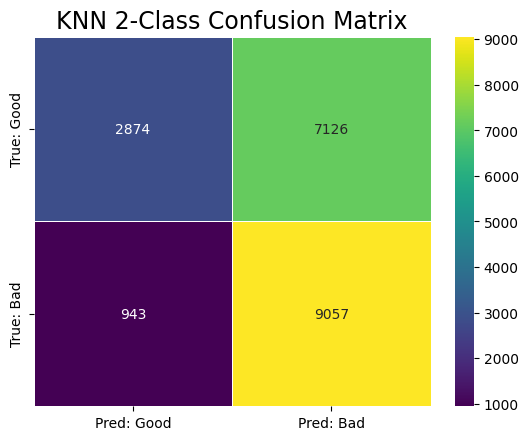

In [ ]:
# printing exact accuracy score
knn_accuracy2c = accuracy_score(ytest2c, knn_preds2c)
print(f"Accuracy of Decison Tree Model: {knn_accuracy2c}")

# evaluating accruacy with classfication report
print(classification_report(ytest2c, knn_preds2c))

# generating a confusion matrix
# from sklearn import metrics

Knn_cm2c = metrics.confusion_matrix(ytest2c, knn_preds2c)

sns.heatmap(Knn_cm2c,
            annot=True,
            fmt='g',
            linewidth=.5,
            xticklabels=['Pred: Good', 'Pred: Bad'],
            yticklabels=['True: Good', 'True: Bad'],
            cmap='viridis')

plt.title('KNN 2-Class Confusion Matrix',fontsize=17)
plt.show()

# ***Artificial Neural Network***

In [ ]:
# parse feature set string
featureSet = 'ChiSq2c250';
numFeatures = 0;
outputSize = 0;

if featureSet == 'ChiSq3c250':
  outputSize = 3;
  numFeatures = 250;
elif featureSet == 'ChiSq3c500':
  outputSize = 3;
  numFeatures = 500;
elif featureSet == 'ChiSq2c250':
  outputSize = 1;
  numFeatures = 250;
elif featureSet == 'ChiSq2c500':
  outputSize = 1;
  numFeatures = 500;

# build ANN model
mdl = keras.Sequential(
    [
      keras.layers.InputLayer((numFeatures,)),
      keras.layers.Dense(16, activation = 'relu', kernel_regularizer = keras.regularizers.L2(1e-4)),
      keras.layers.Dense(outputSize, activation = 'sigmoid'),
    ]
)

mdl.summary();

if outputSize > 1:
  mdl.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()]
  );
else:
  mdl.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()]
  );

keras_visualizer.visualizer(mdl, file_name='graph', file_format='png', view=False, settings=None)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 16)                4016      
                                                                 
 dense_48 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4033 (15.75 KB)
Trainable params: 4033 (15.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# load in data
trainMatrix = sp.load_npz("/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/trainSparseFeatureMatrix" + featureSet + ".npz");
trainMatrix = trainMatrix.todense();
testMatrix = sp.load_npz("/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/testSparseFeatureMatrix" + featureSet + ".npz");
testMatrix = testMatrix.todense();
validMatrix = sp.load_npz("/content/drive/MyDrive/ECE_537_CIS_568/Data/Intermediate/validationSparseFeatureMatrix" + featureSet + ".npz");
validMatrix = validMatrix.todense();

# extract labels
ntr = trainMatrix.shape[0]; ntst = testMatrix.shape[0]; nval = validMatrix.shape[0]; k = trainMatrix.shape[1] - 1;
ytr = np.matrix.copy(trainMatrix[:,0]);
ytst = np.matrix.copy(testMatrix[:,0]);
yval = np.matrix.copy(validMatrix[:,0]);

if outputSize > 1:
  for i in range(0,outputSize):
    ytr = np.hstack((ytr, ytr[:,0] == i));
    ytst = np.hstack((ytst, ytst[:,0] == i));
    yval = np.hstack((yval, yval[:,0] == i));

  ytr = ytr[:,1:]; ytst = ytst[:,1:]; yval = yval[:,1:];

# remove label column from data matrices
trainMatrix = trainMatrix[:,1:];
testMatrix = testMatrix[:,1:];
validMatrix = validMatrix[:,1:];

In [ ]:
# train model
mdl.fit(x = trainMatrix, y = ytr, batch_size = 256, epochs = 10, verbose = 1, validation_data = (validMatrix, yval));

Epoch 1/10
391/391 [==============================] - 5s 9ms/step - loss: 0.5917 - binary_accuracy: 0.7685 - val_loss: 0.4883 - val_binary_accuracy: 0.8169
Epoch 2/10
391/391 [==============================] - 3s 7ms/step - loss: 0.4630 - binary_accuracy: 0.8228 - val_loss: 0.4341 - val_binary_accuracy: 0.8360
Epoch 3/10
391/391 [==============================] - 2s 4ms/step - loss: 0.4313 - binary_accuracy: 0.8316 - val_loss: 0.4175 - val_binary_accuracy: 0.8372
Epoch 4/10
391/391 [==============================] - 1s 3ms/step - loss: 0.4191 - binary_accuracy: 0.8357 - val_loss: 0.4105 - val_binary_accuracy: 0.8423
Epoch 5/10
391/391 [==============================] - 1s 3ms/step - loss: 0.4117 - binary_accuracy: 0.8381 - val_loss: 0.4048 - val_binary_accuracy: 0.8421
Epoch 6/10
391/391 [==============================] - 1s 3ms/step - loss: 0.4062 - binary_accuracy: 0.8386 - val_loss: 0.4009 - val_binary_accuracy: 0.8436
Epoch 7/10
391/391 [==============================] - 1s 3ms/ste

In [ ]:
# perform prediction
ypred = mdl.predict(testMatrix);

938/938 [==============================] - 2s 2ms/step


In [ ]:
print(ytst[2,:]);
print(ypred[2,:]);
acc = np.mean((np.argmax(ytst, axis = 1, keepdims = True) == np.argmax(ypred, axis = 1, keepdims = True)).astype(int));
print(acc);

[[0.]]
[0.3195349]
1.0


In [ ]:
mdl.evaluate(testMatrix, ytst);

625/625 [==============================] - 3s 4ms/step - loss: 0.3477 - binary_accuracy: 0.8461


In [ ]:
if outputSize > 1:
  ypred = (np.argmax(p, axis=0)).reshape((ntst,1));
else:
  ypred = np.transpose(p > 0.5);

idx = ["TruePos", "TrueNeg", "TrueNeu"]; col = ["PredPos", "PredNeg", "PredNeu"];
acc = np.mean(ypred == ytst);
print("Accuracy: ", np.trunc(10000*acc)/100, "%", sep = ""); print("Confusion Matrix:\n");
cm = pd.DataFrame(confusion_matrix(ytst, np.asarray(ypred), labels = classLabels),
                  index = idx[:numC],
                  columns = col[:numC]);
print(cm);

In [ ]:
i = 0; w = [];
for layer in mdl.layers:
  w.append(layer.get_weights());
  i = i+1;

In [ ]:
w[1]

[array([[ 2.3023038],
        [ 1.6989957],
        [-2.4950848],
        [-2.179169 ],
        [-2.4191356],
        [ 1.717624 ],
        [ 2.2759519],
        [-2.4226048],
        [-2.068791 ],
        [-1.9437332],
        [ 2.5128503],
        [-2.422125 ],
        [-2.699239 ],
        [-2.155833 ],
        [ 1.5570756],
        [-2.4002824]], dtype=float32),
 array([0.21453735], dtype=float32)]